# Tutorial 6: Modeling Spot Crossings During Transits

**Author:** Hannu Parviainen <br>
**Edited:** 5 February 2026

This notebook demonstrates how to model spot crossings during exoplanet transits using ExoIris. When a transiting planet crosses a star spot, it temporarily blocks less light than when crossing the normal stellar surface, creating a characteristic "bump" in the light curve. If left unmodeled, these spot crossings can bias the transmission spectrum.

We will analyze real JWST NIRISS observations of HAT-P-18b that contain a clear spot crossing event, showing how to:

1. Identify spot crossings in the data
2. Initialize and configure the spot model
3. Set appropriate priors for spot parameters
4. Fit the data with the spot model
5. Interpret the results

In [1]:
%run ../setup_multiprocessing.py

In [2]:
from multiprocessing import Pool
from numpy import concatenate
from matplotlib.pyplot import subplots, rc
import astropy.io.fits as pf

from exoiris import ExoIris, TSData
from exoiris.ephemeris import Ephemeris

rc('figure', figsize=(12,4))

## Data Loading

We load JWST NIRISS observations of HAT-P-18b from June 2022, which contain a clear spot crossing event visible in the white light curve. The data comes in two spectral orders: Order 1 covers the longer wavelengths (0.9--2.8 $\mu$m) and Order 2 covers the shorter wavelengths (0.62-0.84 $\mu$m). The data is pre-binned both in time and wavelength for this example.

In [3]:
ephemeris = Ephemeris(59743.352, 5.508029, 0.12)

In [4]:
with pf.open('data/hat-p-18b-2022-06-niriss-o1.fits') as hdul:
    d1 = TSData.import_fits('NIRISS-O1', hdul)
    d1.mask_transit(ephemeris=ephemeris)
    d1.estimate_average_uncertainties()
    d1.n_baseline = 1

with pf.open('data/hat-p-18b-2022-06-niriss-o2.fits') as hdul:
    d2 = TSData.import_fits('NIRISS-O2', hdul)
    d2.mask_transit(ephemeris=ephemeris)
    d2.estimate_average_uncertainties()
    d2.n_baseline = 1

d2 = d2.crop_wavelength(0.6, 0.84)
d = d2 + d1

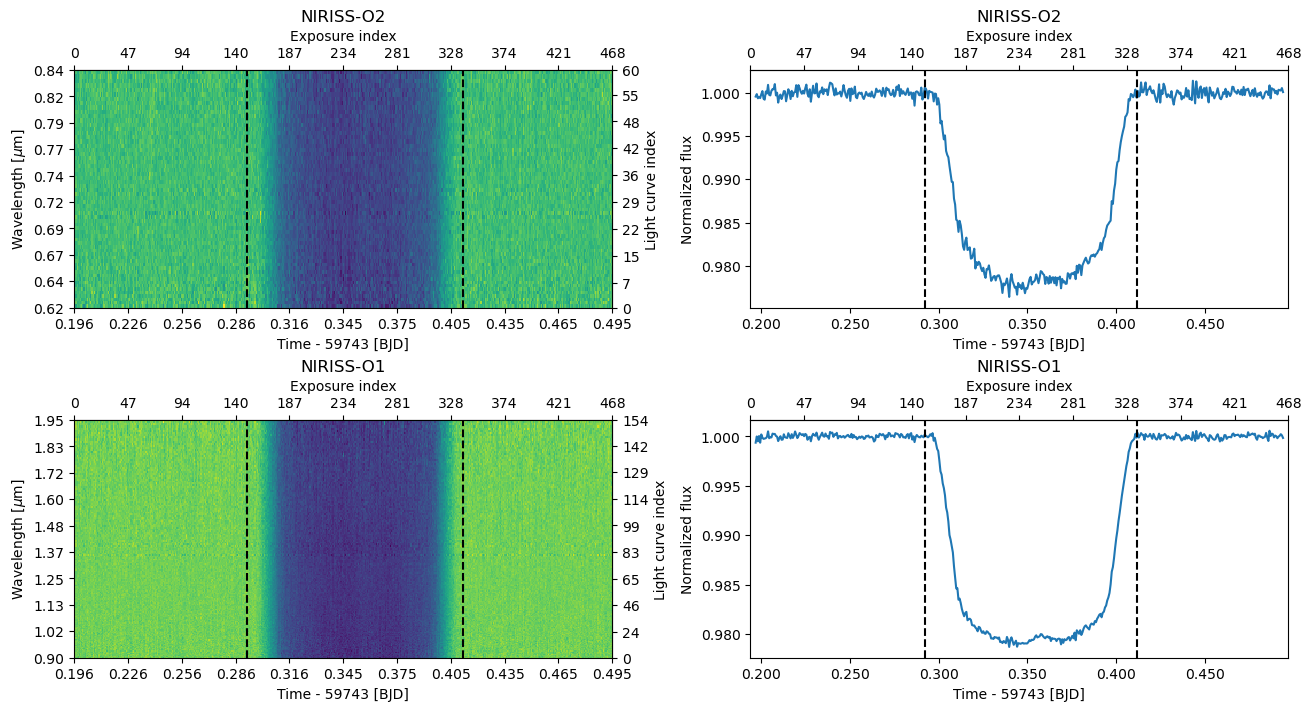

In [5]:
fig, axs = subplots(2, 2, figsize=(13, 7), constrained_layout=True)
d.plot(axs=axs[:,0])
d.plot_white(axs=axs[:,1]);

Look at the white light curves on the right. You can see a clear bump during the transit around BJD 59743.355 - this is the spot crossing event we want to model!

## Understanding Spot Crossings

When a planet transits across a cooler star spot, it temporarily blocks less light than when crossing the normal stellar photosphere. This creates a positive "bump" in the light curve during transit. The amplitude and duration of this bump depend on:

- **Spot size and position:** Larger spots create bigger bumps; position determines when during transit the bump appears
- **Spot temperature:** Cooler spots create larger amplitude bumps
- **Wavelength:** The contrast between spot and photosphere is wavelength-dependent, typically stronger at shorter wavelengths

ExoIris models spot crossings using the following parameters:

| Parameter | Name | Description |
|-----------|------|-------------|
| `spc_XX` | Center | Time of maximum spot crossing amplitude |
| `spa_XX` | Amplitude | Maximum flux anomaly at the reference wavelength |
| `spw_XX` | FWHM | Full width at half maximum (duration) of the crossing |
| `sps_XX` | Shape | Shape parameter, where 2 gives a Gaussian |
| `spt_XX` | Temperature | Effective temperature of the spot |

The wavelength-dependent contrast is computed using BT-Settl stellar atmosphere models, so you only need to specify the spot temperature - ExoIris handles the spectral contrast automatically.

## Initialize ExoIris with Spot Model

In [6]:
ts = ExoIris('06_spot_crossing', 'power-2', d, nk=50, nthreads=1)
ts.set_prior('tc_00', 'NP', ephemeris.zero_epoch, 0.003)
ts.set_prior('p', 'NP', ephemeris.period, 1e-7)
ts.set_prior('rho', 'NP', 2.68, 0.2)
ts.set_prior('radius ratios', 'UP', 0.125, 0.145)
ts.set_ldtk_prior((4790, 120), (4.58, 0.01), (0.14, 0.1), uncertainty_multiplier=10)

### Add the Spot Model

Now we initialize the spot model and add a spot. The key parameters are:

- `tstar`: Stellar effective temperature (K) - used for contrast calculations
- `wlref`: Reference wavelength ($\mu$m) where the spot amplitude is defined
- `include_tlse`: Whether to include Transit Light Source Effect (unocculted spots/faculae)

In [7]:
ts.initialize_spots(tstar=4790, wlref=1.5, include_tlse=False)
ts.add_spot(epoch_group=0)

Let's examine the new spot parameters that have been added to the model:

In [8]:
ts.ps[-10:]

[ 72 |G| k_01.86618     U(a = 0.125, b = 0.145)                  [    0.00 ..      inf],
  73 |G| k_01.89324     U(a = 0.125, b = 0.145)                  [    0.00 ..      inf],
  74 |G| k_01.92030     U(a = 0.125, b = 0.145)                  [    0.00 ..      inf],
  75 |G| k_01.94735     U(a = 0.125, b = 0.145)                  [    0.00 ..      inf],
  76 |G| sigma_m_00     N(μ = 1.0, σ = 0.01)                     [    0.00 ..      inf],
  77 |G| spc_01         U(a = 0, b = 1)                          [    0.00 ..      inf],
  78 |G| spa_01         U(a = 0, b = 1)                          [    0.00 ..      inf],
  79 |G| spw_01         U(a = 0, b = 1)                          [    0.00 ..      inf],
  80 |G| sps_01         U(a = 1, b = 5)                          [    0.00 ..      inf],
  81 |G| spt_01         U(a = 3000, b = 6000)                    [    0.00 ..      inf]]

## Set Spot Priors

We need to set appropriate priors for the spot parameters based on our visual inspection of the data:

- **Center time (`spc_01`)**: The bump appears around BJD 59743.355
- **Amplitude (`spa_01`)**: The bump is small, maybe ~0.1% of the flux
- **FWHM (`spw_01`)**: The bump lasts roughly 0.01-0.02 days
- **Temperature (`spt_01`)**: Spot should be cooler than the star (4790 K)

In [9]:
ts.set_prior('spc_01', 'NP', 59743.355, 0.001)  # Normal prior on center time
ts.set_prior('spa_01', 'UP', 0.0, 0.002)        # Uniform prior on amplitude
ts.set_prior('spw_01', 'UP', 0.001, 0.05)       # Uniform prior on FWHM
ts.set_prior('spt_01', 'UP', 3850, 4790)        # Uniform prior on temperature (must be < Tstar)

In [10]:
ts.ps[-6:]

[ 76 |G| sigma_m_00     N(μ = 1.0, σ = 0.01)                     [    0.00 ..      inf],
  77 |G| spc_01         N(μ = 59743.355, σ = 0.001)              [    0.00 ..      inf],
  78 |G| spa_01         U(a = 0.0, b = 0.002)                    [    0.00 ..      inf],
  79 |G| spw_01         U(a = 0.001, b = 0.05)                   [    0.00 ..      inf],
  80 |G| sps_01         U(a = 1, b = 5)                          [    0.00 ..      inf],
  81 |G| spt_01         U(a = 3850, b = 4790)                    [    0.00 ..      inf]]

Let's visualize the model setup including the radius ratio and limb darkening knots:

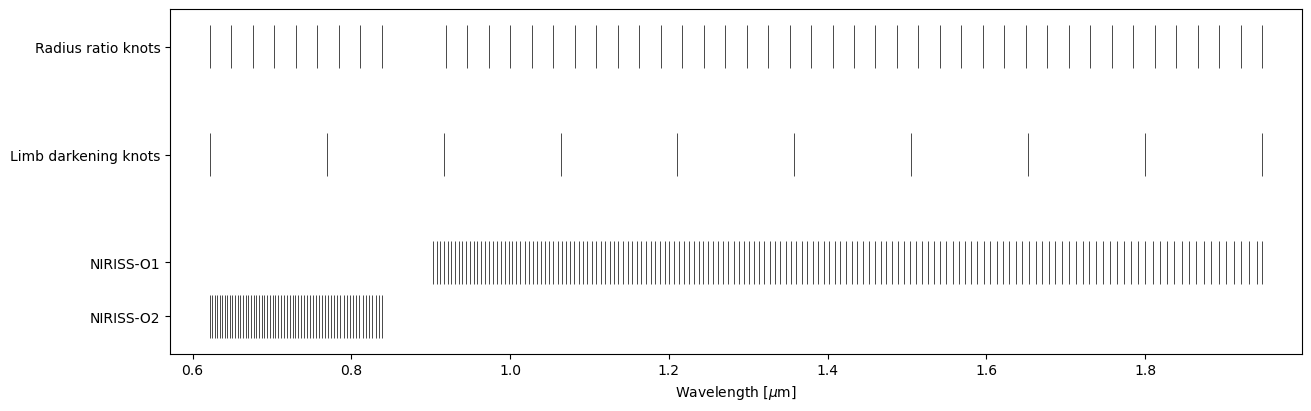

In [11]:
knots = ts.k_knots.copy()
m = (knots > ts.data[0].bbox_wl[1]) & (knots < ts.data[1].bbox_wl[0])
ts.set_radius_ratio_knots(knots[~m])

ts.plot_setup(figsize=(13, 4));

## Fitting the Model

### Fit the White Light Curve

We start by fitting the white light curve to obtain initial estimates of the orbital and planetary parameters. Note that the white light curve fit doesn't include the spot model.

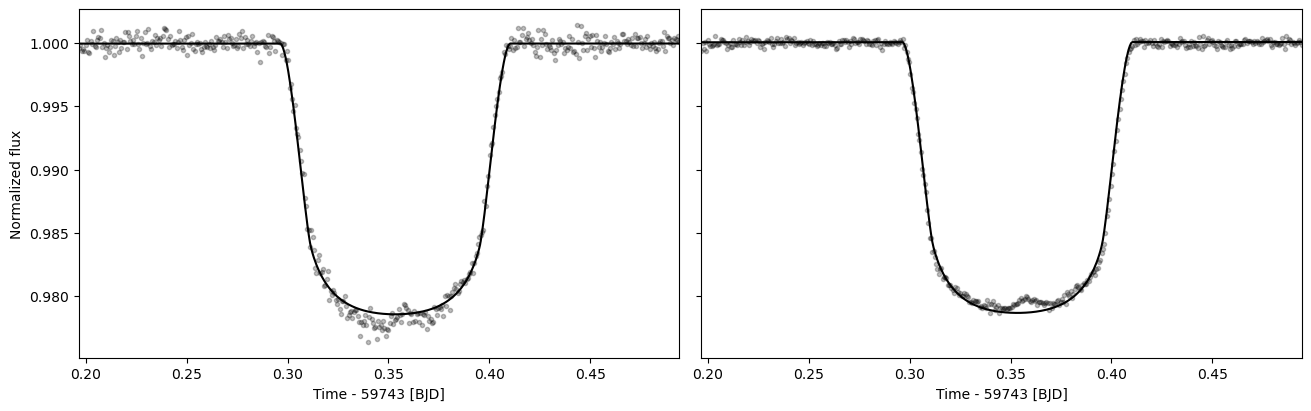

In [12]:
ts.fit_white()
ts.plot_white(figsize=(13, 4));

### Set Up Multiprocessing

In [13]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

### Global Optimization

Global optimisation:   0%|          | 0/5000 [00:00<?, ?it/s]

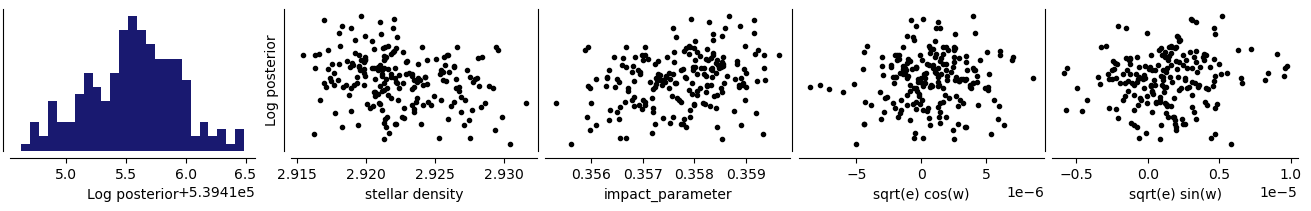

In [14]:
ts.fit(niter=5000, npop=200, pool=pool, lnpost=lnpostf)

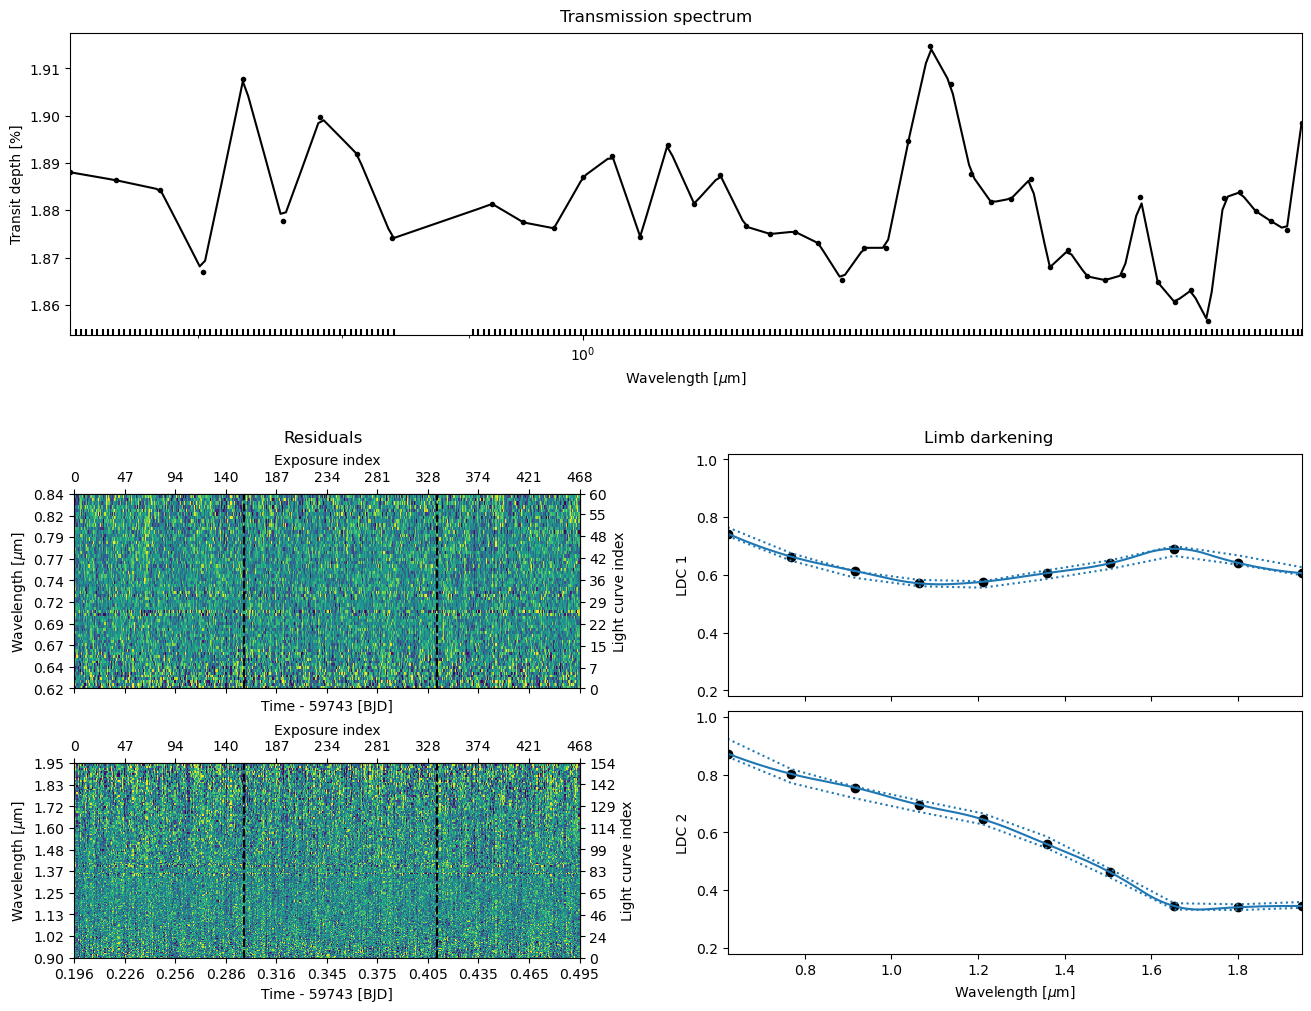

In [15]:
ts.plot_fit(figsize=(13, 10), height_ratios=(1, 1.5), trs_args={'xscale': 'log'});

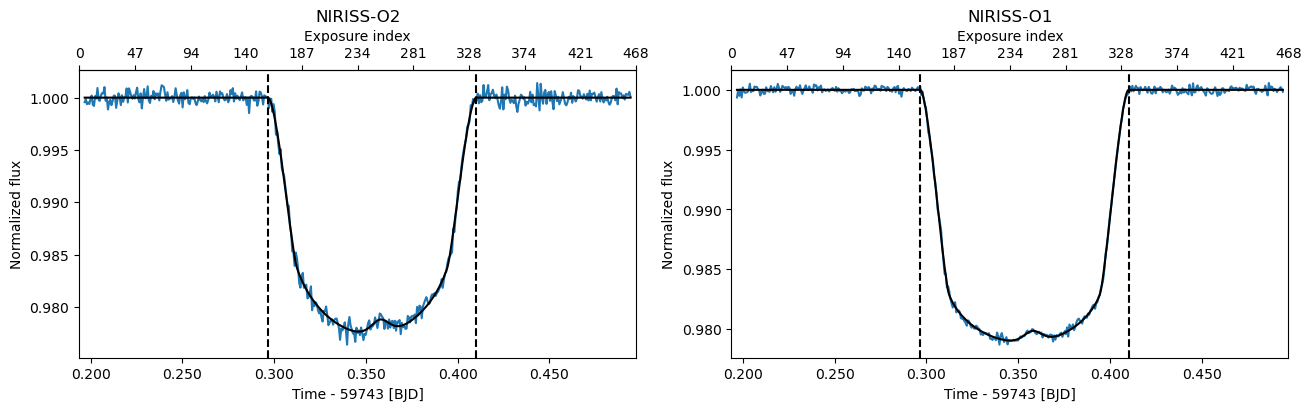

In [16]:
mtr = ts._tsa.flux_model(ts._tsa.de.minimum_location, include_baseline=False)

fig, axs = subplots(1, 2, figsize=(13, 4), constrained_layout=True)
for i in range(2):
    ts.data[i].plot_white(ax=axs[i])
    axs[i].plot(ts.data[i].time, ts.data[i].create_white_light_curve(mtr[i][0]), 'k')

## MCMC Sampling

With a good optimization result, we can now run MCMC to obtain posterior samples.

In [19]:
ts.sample(1000, thin=50, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

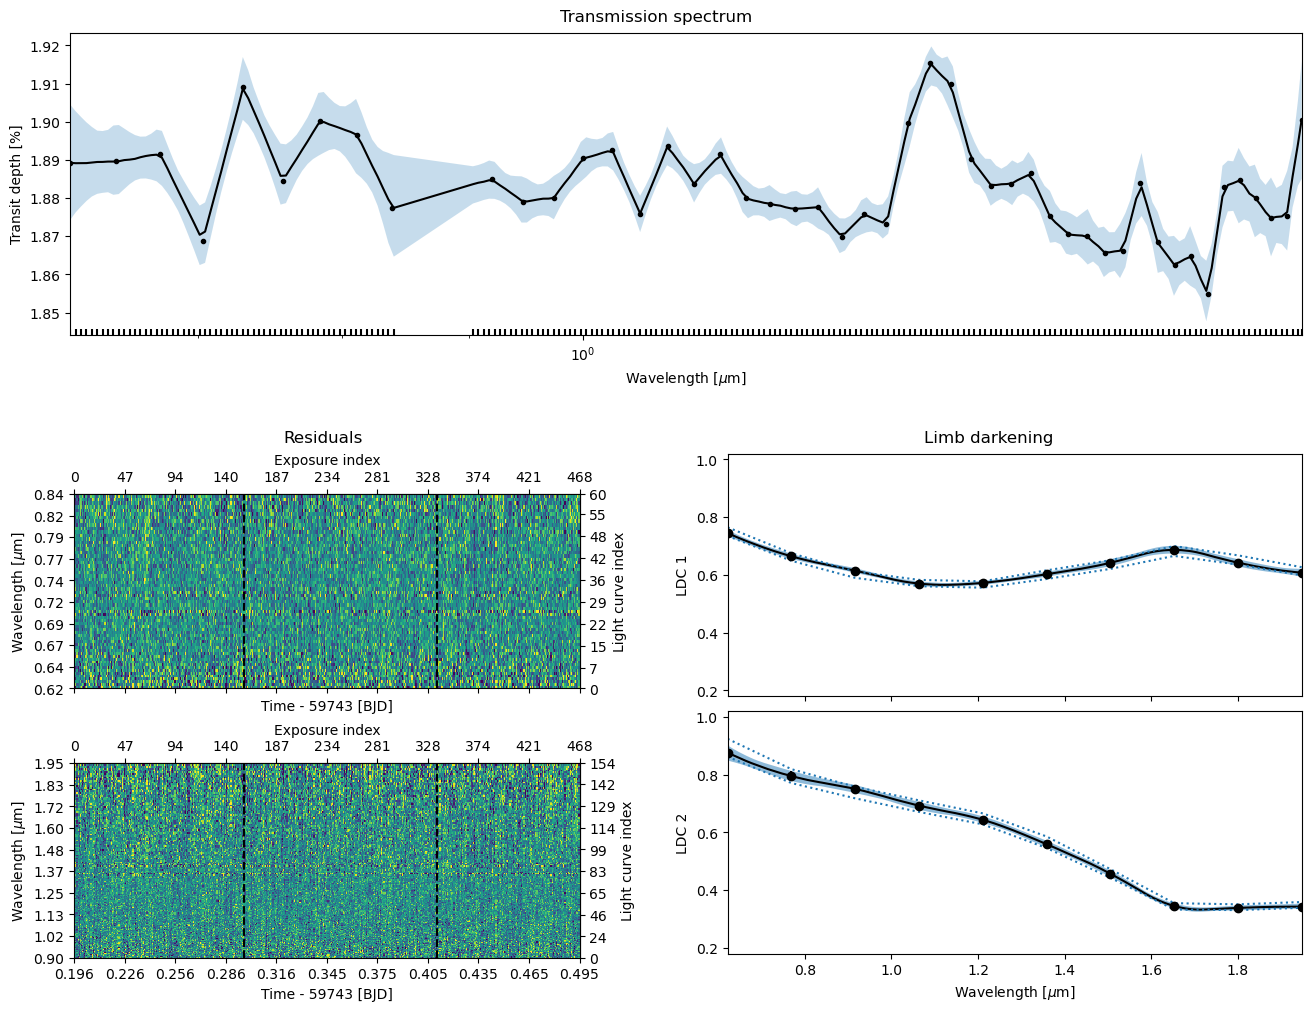

In [20]:
ts.plot_fit('mcmc', figsize=(13, 10), height_ratios=(1, 1.5), trs_args={'xscale': 'log'});

### Spot Parameter Posteriors

Let's examine the posterior distributions for the spot parameters.

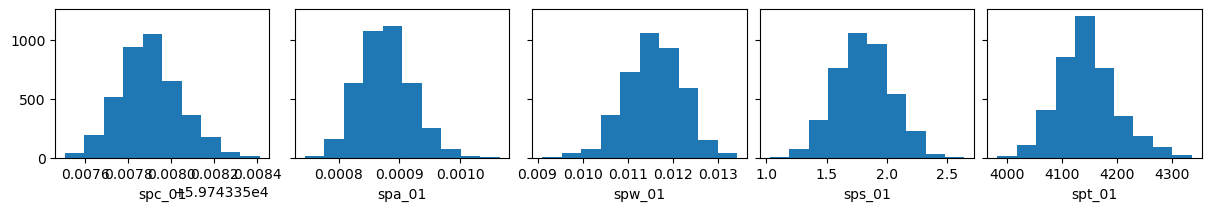

In [21]:
spot_cols = [c for c in ts.posterior_samples.columns if c.startswith('sp')]
fig, axs = subplots(1, len(spot_cols), figsize=(12, 2), constrained_layout=True, sharey='all')
for i, ax in enumerate(axs):
    ax.hist(ts.posterior_samples[spot_cols[i]])
    ax.set_xlabel(spot_cols[i])

## Save and Cleanup

In [22]:
ts.save(overwrite=True)

In [23]:
pool.close()

---

<center>&copy;2026 Hannu Parviainen</center>